In [2]:
import os
import urllib.request
import tarfile

def download_and_extract_pets(url, dataset_dir, filename):
    if not os.path.exists(dataset_dir):  # 디렉토리 없으면 생성
        os.makedirs(dataset_dir)
    dataset_path = os.path.join(dataset_dir, filename)
    if not os.path.exists(dataset_path):  # 파일 없으면 다운로드
        print(f"Downloading {filename}...")
        urllib.request.urlretrieve(url, dataset_path)
        print(f"{filename} download complete.")

    with tarfile.open(dataset_path) as tar:  # 압축 해제
        print(f"Extracting {filename}...")
        tar.extractall(path=dataset_dir)
        print(f"{filename} extraction complete.")

# URL과 데이터셋 디렉토리 설정
images_url = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"
annotations_url = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"
dataset_directory = "./oxford_iiit_pets"

# 이미지 데이터 다운로드 및 추출
download_and_extract_pets(images_url, dataset_directory, "images.tar.gz")

# 어노테이션 데이터 다운로드 및 추출
download_and_extract_pets(annotations_url, dataset_directory, "annotations.tar.gz")

images.tar.gz download complete.
Extracting images.tar.gz...
images.tar.gz extraction complete.
annotations.tar.gz download complete.
Extracting annotations.tar.gz...
annotations.tar.gz extraction complete.


In [3]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

class OxfordPetsDataset(Dataset):
    def __init__(self, img_dir, annotation_file, transform=None, target_transform=None):
        """
        Oxford-IIIT Pet Dataset 클래스 (어노테이션 파일 기반 라벨링)

        Args:
            img_dir (str): 이미지 파일이 저장된 디렉토리 경로.
            annotation_file (str): 어노테이션 파일 경로.
            transform (callable, optional): 이미지에 적용할 변환 함수.
            target_transform (callable, optional): 레이블에 적용할 변환 함수.
        """
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        # 어노테이션 파일에서 이미지와 라벨 로드
        self.img_labels = self._load_labels(annotation_file)

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # 이미지 경로와 라벨 가져오기
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]

        # 변환 적용
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

    def _load_labels(self, annotation_file):
        """
        어노테이션 파일에서 이미지와 라벨을 로드하는 함수.
        """
        try:
            # 어노테이션 파일 읽기 (공백 구분 및 열 자동 감지)
            labels_df = pd.read_csv(
                annotation_file,
                sep="\s+",  # 공백(하나 이상)을 구분자로 사용
                header=None,  # 헤더가 없음을 지정
                engine='python'  # Python 엔진 사용으로 복잡한 구조 처리
            )

            # 파일 이름과 클래스 ID만 선택
            labels_df = labels_df.iloc[:, [0, 1]]  # 첫 번째와 두 번째 열 사용
            labels_df.columns = ["file_name", "class_id"]  # 열 이름 지정

        except Exception as e:
            print(f"Error loading annotation file: {e}")
            raise

        return labels_df

In [4]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms


# 수정된 OxfordPetsDataset 클래스
class OxfordPetsDataset(Dataset):
    def __init__(self, img_dir, annotation_file, transform=None, target_transform=None):
        """
        Oxford-IIIT Pet Dataset 클래스 (어노테이션 파일 기반 라벨링)

        Args:
            img_dir (str): 이미지 파일이 저장된 디렉토리 경로.
            annotation_file (str): 어노테이션 파일 경로.
            transform (callable, optional): 이미지에 적용할 변환 함수.
            target_transform (callable, optional): 레이블에 적용할 변환 함수.
        """
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.img_labels = self._load_labels(annotation_file)

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # 이미지 경로와 라벨 가져오기
        img_file = self.img_labels.iloc[idx, 0] + ".jpg"  # 확장자 추가
        img_path = os.path.join(self.img_dir, img_file)
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]

        # 변환 적용
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

    def _load_labels(self, annotation_file):
        """
        어노테이션 파일에서 이미지와 라벨을 로드하는 함수.
        """
        labels_df = pd.read_csv(
            annotation_file,
            sep=" ",
            header=None,
            names=["file_name", "class_id", "species", "breed_id"]
        )
        labels_df = labels_df[["file_name", "class_id"]]
        return labels_df


# 데이터 디렉토리 및 파일 경로 설정
img_dir = "./oxford_iiit_pets/images"  # 이미지 디렉토리
train_annotation_file = "./oxford_iiit_pets/annotations/trainval.txt"
test_annotation_file = "./oxford_iiit_pets/annotations/test.txt"

# 데이터 변환 정의
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Train/Validation 데이터셋 초기화
trainval_dataset = OxfordPetsDataset(img_dir, train_annotation_file, transform=transform)

# Train/Validation 데이터셋 분할 (9:1 비율)
train_size = int(0.9 * len(trainval_dataset))
val_size = len(trainval_dataset) - train_size
train_dataset, val_dataset = random_split(trainval_dataset, [train_size, val_size])

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# Test 데이터셋 초기화
test_dataset = OxfordPetsDataset(img_dir, test_annotation_file, transform=transform)
print(f"Test dataset size: {len(test_dataset)}")

# 데이터 로더 생성
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 샘플 데이터 확인
for images, labels in train_dataloader:
    print(f"Train batch - Images shape: {images.shape}, Labels: {labels}")
    break

for images, labels in val_dataloader:
    print(f"Validation batch - Images shape: {images.shape}, Labels: {labels}")
    break

for images, labels in test_dataloader:
    print(f"Test batch - Images shape: {images.shape}, Labels: {labels}")
    break


Train dataset size: 3312
Validation dataset size: 368
Test dataset size: 3669
Train batch - Images shape: torch.Size([16, 3, 128, 128]), Labels: tensor([23, 26, 12,  5, 21, 21, 30, 21, 10,  3,  8, 21, 24, 16, 15, 13])
Validation batch - Images shape: torch.Size([16, 3, 128, 128]), Labels: tensor([31,  4, 37, 26, 25, 35, 31, 27, 11, 29, 29,  8,  9,  3, 32, 27])
Test batch - Images shape: torch.Size([16, 3, 128, 128]), Labels: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


In [11]:
import torch
import torch.nn as nn

class BasicBlock(nn.Module):

    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels * BasicBlock.expansion)

        self.activation = nn.ReLU()

        self.skip = nn.Sequential()
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.skip(x)
        out = self.activation(out)

        return out

class ResNet18(nn.Module):
    def __init__(self, block):
        super(ResNet18, self).__init__()
        torch.manual_seed(2024)

        self.in_channels = 64

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.make_layer(block, 64, 2, stride=1)
        self.layer2 = self.make_layer(block, 128, 2, stride=2)
        self.layer3 = self.make_layer(block, 256, 2, stride=2)
        self.layer4 = self.make_layer(block, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=0.5)
        self.affine = nn.Linear(512 * block.expansion, 100)

        self.activation = nn.ReLU()

    def make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for i in range(num_blocks):
            layers.append(block(self.in_channels, out_channels, strides[i]))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.affine(x)

        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18(BasicBlock).to(device)

print(sum(p.numel() for p in model.parameters()))

learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30], gamma=0.1) #learning rate decay
criterion = nn.CrossEntropyLoss()

11220196


Epoch [1/55]
  Train Loss: 4.0752, Train Acc: 0.0329
  Val Loss: 3.7099, Val Acc: 0.0299
Epoch [2/55]
  Train Loss: 3.7354, Train Acc: 0.0432
  Val Loss: 3.6675, Val Acc: 0.0326
Epoch [3/55]
  Train Loss: 3.6473, Train Acc: 0.0543
  Val Loss: 3.5538, Val Acc: 0.0516
Epoch [4/55]
  Train Loss: 3.5808, Train Acc: 0.0610
  Val Loss: 3.5484, Val Acc: 0.0707
Epoch [5/55]
  Train Loss: 3.5278, Train Acc: 0.0634
  Val Loss: 3.4356, Val Acc: 0.0897
Epoch [6/55]
  Train Loss: 3.4386, Train Acc: 0.0906
  Val Loss: 3.3283, Val Acc: 0.1141
Epoch [7/55]
  Train Loss: 3.3685, Train Acc: 0.0939
  Val Loss: 3.2860, Val Acc: 0.1005
Epoch [8/55]
  Train Loss: 3.3055, Train Acc: 0.1093
  Val Loss: 3.4296, Val Acc: 0.0978
Epoch [9/55]
  Train Loss: 3.2688, Train Acc: 0.1147
  Val Loss: 3.1994, Val Acc: 0.1440
Epoch [10/55]
  Train Loss: 3.1982, Train Acc: 0.1286
  Val Loss: 3.3852, Val Acc: 0.0978
Epoch [11/55]
  Train Loss: 3.1374, Train Acc: 0.1425
  Val Loss: 3.0562, Val Acc: 0.1332
Epoch [12/55]
  Tra

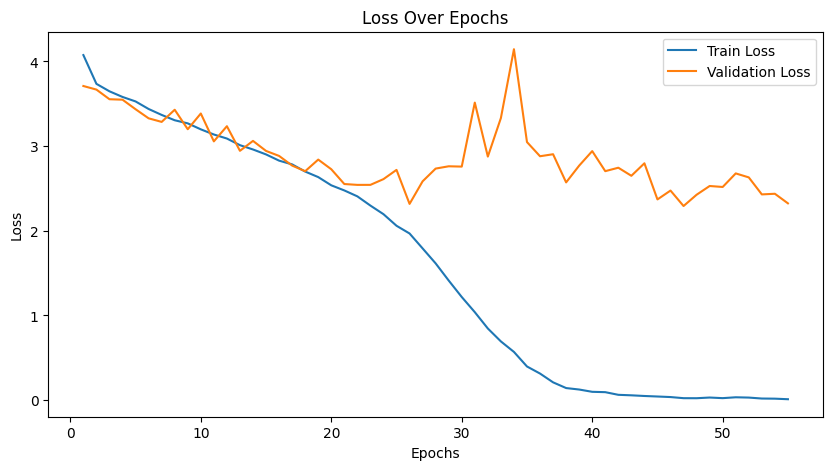

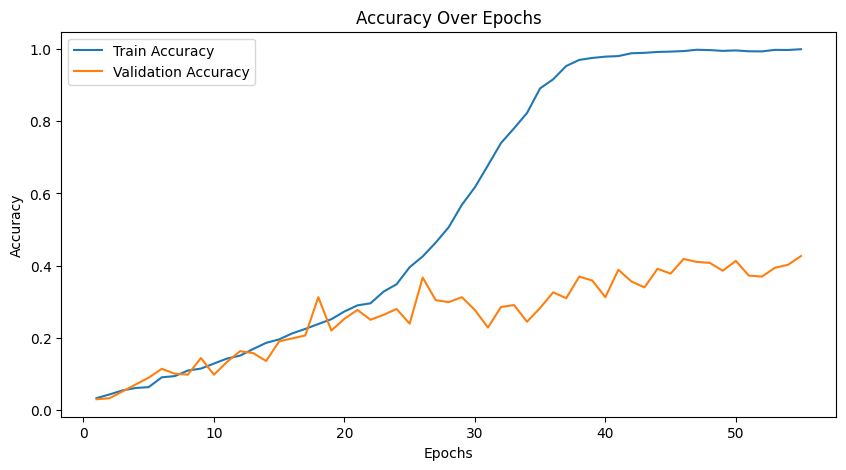

In [12]:
import matplotlib.pyplot as plt

# 학습 함수
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total

# 검증 함수
def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total

# 학습 루프
num_epochs = 55
best_val_acc = 0.0

# 결과 저장을 위한 리스트
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_dataloader, optimizer, criterion, device)
    val_loss, val_acc = validate_one_epoch(model, val_dataloader, criterion, device)

    # 스케줄러 업데이트
    train_scheduler.step()

    # 결과 저장
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # 검증 정확도 업데이트
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")  # 최고 모델 저장

    # 학습 결과 출력
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

print(f"Best Validation Accuracy: {best_val_acc:.4f}")

# 학습 및 검증 결과 시각화
epochs = range(1, num_epochs + 1)

# Loss 시각화
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy 시각화
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
# 테스트 함수
def test_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    test_loss = running_loss / total
    test_accuracy = correct / total
    return test_loss, test_accuracy

# 테스트 데이터에 대한 정확도 계산
test_loss, test_accuracy = test_model(model, test_dataloader, criterion, device)

# 결과 출력
print("Test Results:")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Test Accuracy: {test_accuracy:.4f}")

Test Results:
  Test Loss: 2.8599
  Test Accuracy: 0.3521


# Oxford-IIIT Pet Dataset 개요
### **주요 특징**

#### **이미지 크기**
- 다양한 크기의 이미지로 제공되며, **고화질 RGB 컬러 이미지**로 구성되어 있습니다.
- 각 이미지의 해상도는 고정되어 있지 않으며, 다양한 크기와 비율로 제공됩니다.

#### **클래스 수**
- 총 **37개 품종**(강아지 25종, 고양이 12종)으로 구성되어 있습니다.
- 각 품종은 **약 200개의 이미지**를 포함하고 있습니다.

#### **데이터 분할**
- 총 **7,349개의 이미지**가 제공됩니다.
  - **Training Set**: 3,680개
  - **Test Set**: 3,669개
- 데이터는 학습과 테스트에 적합하도록 미리 분할되어 있습니다.

#### **세그멘테이션 데이터**
- **픽셀 단위로 라벨링된 세그멘테이션 마스크**가 제공되며, 애완동물과 배경을 구분할 수 있습니다.
- 세그멘테이션은 이미지 내의 특정 영역(예: 동물의 윤곽)을 학습하고 예측하는 데 활용됩니다.

#### **다양한 데이터 변형**
- **배경, 조명, 각도, 위치** 등이 다양하게 변형된 데이터를 포함하여, 현실적인 시나리오를 반영합니다.


# 데이터 전처리

Oxford-IIIT Pet Dataset을 모델 학습에 적합하도록 변환하기 위해 다음과 같은 데이터 전처리를 수행합니다:

1. **PIL 이미지 변환**  
   - PyTorch의 `read_image`로 로드된 이미지는 텐서 형식입니다.
   - 이를 `transforms.ToPILImage()`를 사용해 PIL 이미지로 변환합니다.

2. **이미지 크기 조정 (Resize)**  
   - 이미지는 다양한 크기로 제공되므로, 모델 입력에 맞춰 **128x128 크기로 조정**합니다.

3. **RGB 변환**  
   - 일부 흑백 이미지가 포함되어 있을 수 있으므로, `transforms.Lambda(lambda img: img.convert("RGB"))`를 사용해 **3채널(RGB)**로 변환합니다.

4. **텐서 변환 (ToTensor)**  
   - PIL 이미지를 PyTorch 텐서로 변환하여 모델 학습에 사용합니다.
   - 변환된 텐서는 `[C, H, W]` 형식 (채널, 높이, 너비)을 가집니다.

5. **정규화 (Normalize)**  
   - 각 픽셀 값을 평균(mean) 0.5, 표준편차(std) 0.5로 정규화하여 **[-1, 1] 범위**로 변환합니다.
   - 정규화는 학습 안정성과 모델 수렴 속도를 높이는 데 도움을 줍니다.

# 분석 및 고찰

### 1. **모델 학습 결과**

학습 초기에 손실 값이 빠르게 감소하며 정확도가 소폭 증가함. 이는 모델이 데이터를 점진적으로 학습하고 있음을 보였습니다. 훈련 데이터와 검증 데이터 모두에서 성능이 지속적으로 향상되었지만, epoch 25 이후 Val Loss와 Train Loss의 격차가 점점 벌어지며 **오버피팅** 징후가 보이기 시작했습니다. epoch 40 이후, 훈련 데이터에서는 성능이 급격히 좋아졌으나, 검증 데이터에서는 Val Loss의 증가와 Val Acc의 정체가 발생하면서 학습이 진행됨에 따라 오버피팅이 심화되었음을 볼 수 있었습니다.

### 2. **모델 및 하이퍼파라미터 설정**
#### 강점
- **ResNet18 아키텍처 활용:** BasicBlock을 사용해 깊은 네트워크를 구성. 잔차 연결로 인해 그래디언트 소실 문제를 효과적으로 해결했습니다.
- **Dropout 추가:** Fully Connected Layer에 Dropout을 추가하여 일부 과적합 문제를 완화했습니다.
- **Learning Rate Decay:** Epoch 30에서 학습률 감소를 적용하여 학습 안정화했습니다.

#### 한계
- **초기 Learning Rate:** 0.1로 설정되어 학습이 빠르게 진행되었으나, 초기 손실 값이 크게 튀는 현상이 발생하였습니다. 초기 학습률을 0.01로 낮추는 것이 더 적합할 가능성이 있습니다.  
- **오버피팅:** Train Loss와 Val Loss의 차이가 Epoch 25 이후 점차 증가하는 모습을 보였습니다. Dropout과 Weight Decay 외에도 **Data Augmentation**을 강화하거나, **Weight Decay**를 적용하는 방법이 필요합니다.

### 3. **결론**
ResNet18 아키텍처를 활용한 모델은 초기 학습에서 빠르게 수렴하였으나, 후반부로 갈수록 과적합 문제가 발생하여 검증 데이터의 성능이 제한되었습니다. 추가적인 정규화 기법과 데이터 증강을 통해 일반화 성능을 개선할 수 있습니다. Data Augmentation이나 Weight Decay 등의 정규화 항을 통해 오버피팅 문제를 완화하고, 검증 성능을 더욱 높이는 방향으로 실험을 진행해야 할 것입니다.